In [1]:
using Revise
using LinearAlgebra
using MatrixMarket
using EAMC
using SparseArrays
using Plots
using Interact

┌ Info: Precompiling EAMC [d0d32b4c-83b1-4490-9109-c03fdd3b1e42]
└ @ Base loading.jl:1273
  ** incremental compilation may be fatally broken for this module **



HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-391545199372145938\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-5193881284308309824\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-391545199372145938\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-17189051001309477743\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-1305677754262304082\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-17189051001309477743\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [2]:
## load data
using MatrixMarket
data = cd("data/natalia191219") do 
    map(MatrixMarket.mmread, readdir())
end;

In [3]:
## adjust diagonal to be a proper q matrix
using LinearAlgebra
qs = data
qs = map(qs) do q
    q = q * 0.36
    q .- Diagonal(sum(q, dims=2)|>vec) # mass conservation
end;

In [4]:
## galerkin discretization of the eamc
using EAMC
dt = ones(length(qs))
dt[end] = 1000
tmax = length(qs)
g = @time EAMC.galerkin(qs[1:tmax], dt[1:tmax]);

  6.835251 seconds (4.29 M allocations: 4.771 GiB, 16.82% gc time)


In [5]:
cs = EAMC.commitors(g, 900)
cc = reshape(cs, 30, 30, 24, 30, 30);

DimensionMismatch: DimensionMismatch("new dimensions (30, 30, 24, 30, 30) must be consistent with array size 20250000")

In [6]:
using Plots
@manipulate for x=slider(1:30, 15, label="x"), y=slider(1:30, 15, label="y"), t=slider(1:24, 1, label="t")
heatmap(cc[:,:,t,y,x], title="Commitor von (x=$x,y=$y,t=24) zum zeitpunkt t=$t")
end

UndefVarError: UndefVarError: cc not defined

In [7]:
## restrict clustering area to the center
tcluster = 12 # timepoint at which to seperate the clusters
xmin, xmax, ymin, ymax = 1,30,1,30
M = reshape(cc[xmin:xmax, ymin:ymax, tcluster, xmin:xmax, ymin:ymax], 30*30*1, 30*30)
#css = css ./ sqrt.(sum(css, dims=1))
#M = reshape(cc[:,:,12,:,:], 30*30, 30*30)

M = M' * M
M = M - Diagonal(M)
M = M ./ sum(M, dims=2);

UndefVarError: UndefVarError: cc not defined

In [9]:
include("src/pccap.jl")
nc = 6
p = pccap(M, nc, optimize=true)
# now sort by cluster size
p = p[:,sortperm(sum(p, dims=1)|>vec, rev=true)];

In [10]:
cl = reshape(cc[:,:,:, xmin:xmax, ymin:ymax], 30*30*24, 30*30) * p
cl = reshape(cl, 30, 30, 24, nc);

In [11]:
using Interact
gr()
@manipulate for i = 1:24, c=1:nc
heatmap(log.(cl[:,:,i,c].+1), title="pccap on center, t=$i", clims=(0,.3))
    end

@manipulate for i = 1:24, c=1:nc
heatmap(cl[:,:,i,c], title="pccap on center, t=$i")
    end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 24,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
12, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/Users/alex/.julia/packages/Knockout/1sDlc/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/alex/.julia/packages/Knockout/1sDlc/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/alex/.julia/packages/InteractBase/9mFwe/src/../assets/all.js"), Asset("css", nothing, "/Users/alex/.julia/packages/InteractBase/9mFwe/src/../assets/style.css"), Asset("css", nothing, "/Users/alex/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000012b39cb50, Task (runnable) @0x000000012b39cb50), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"6080811516492670462\",\"id\":\"ob_

┌ Info: Saved animation to 
│   fn = /Users/alex/Desktop/code/generators/tmp.gif
└ @ Plots /Users/alex/.julia/packages/Plots/qZHsp/src/animation.jl:98


Plots.AnimatedGif("/Users/alex/Desktop/code/generators/tmp.gif")
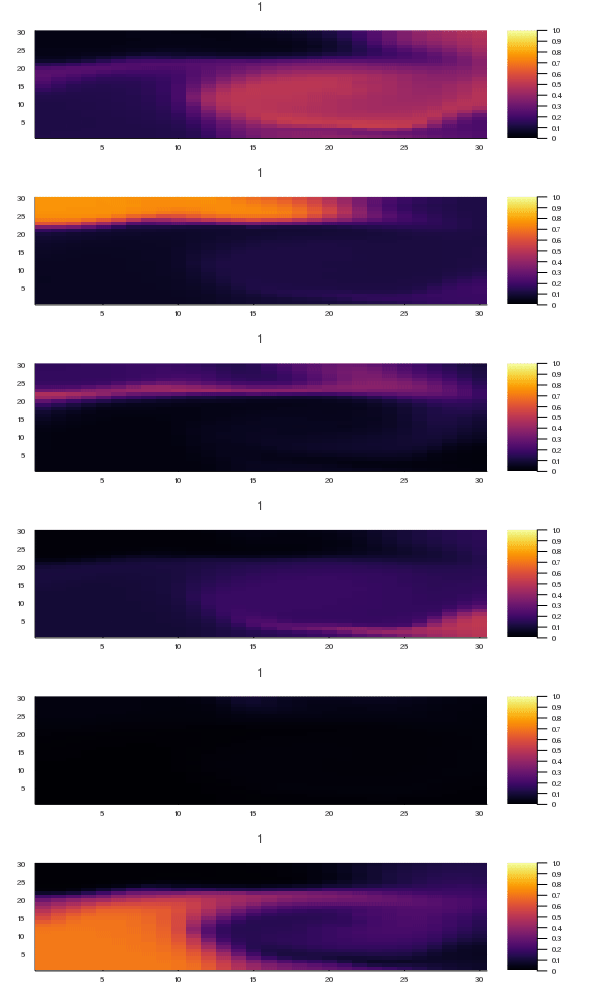

In [12]:

anim = @animate for t=1:24
plot([heatmap(cl[:,:,t,c]) for c=1:nc]..., layout=grid(nc,1), size=(600,1000), title="$t", clims=(0,1))
end

gif(anim, fps=6)